In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from embeddings import get_embedding_matrix, sentence_to_indexes
from emb_path import glove_6B_300d_path, lexvec_7B_300d_path, glove_6B_50d_path
from sklearn.metrics.pairwise import cosine_similarity
from gem import SentenceEmbedder
from scipy.stats import pearsonr
from utils import read_sts
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
sts_dev = read_sts('data/sts_benchmark/sts-dev.csv')
sts_test = read_sts('data/sts_benchmark/sts-test.csv')

In [3]:
sts_dev.shape, sts_test.shape

((1500, 3), (1379, 3))

In [4]:
sts_test.head()

,score,sentence1,sentence2
0,2.5,A girl is styling her hair.,A girl is brushing her hair.
1,3.6,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.
2,5.0,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.
3,4.2,A man is cutting up a cucumber.,A man is slicing a cucumber.
4,1.5,A man is playing a harp.,A man is playing a keyboard.


In [5]:
def pred(ind, sim):
    n1 = sim.shape[0] // 2
    return sim[ind, n1+ind]

In [6]:
%%time

dfs = {"(sts-dev)": sts_dev,
       "(sts-test)": sts_test}
embds = {"Glove": get_embedding_matrix(glove_6B_300d_path)}
         #"LexVec": get_embedding_matrix(lexvec_7B_300d_path, islexvec=True)}

CPU times: user 24.7 s, sys: 2.72 s, total: 27.4 s
Wall time: 28.4 s


In [7]:
%%time

print('Unigrams:\n\n')

for df_name, df in dfs.items():
    sentences = df.sentence1.values.tolist() + df.sentence2.values.tolist()
    for e_name, (e, v) in embds.items():
        model = SentenceEmbedder(sentences, e, v, False)
        result, s = model.gem(sigma_power=3)
        sim = cosine_similarity(result)
        df['pred'] = df.apply(lambda row: pred(row.name, sim), axis=1)
        corr = df.corr().iloc[0, 1]
        print("{:>8} + {:<8} {:>10}: {:<10}".format('GEM', e_name, df_name, corr))
        
        result, s = model.mean_embeddings()
        sim = cosine_similarity(result)
        df['pred'] = df.apply(lambda row: pred(row.name, sim), axis=1)
        corr = df.corr().iloc[0,1]
        print("{:>8} + {:<8} {:>10}: {:<10}".format('Mean', e_name, df_name, corr))

Unigrams:


     GEM + Glove     (sts-dev): 0.7889738550639861
    Mean + Glove     (sts-dev): 0.5179574524949324
     GEM + Glove    (sts-test): 0.635855355833978
    Mean + Glove    (sts-test): 0.23765156814800037
CPU times: user 1min 6s, sys: 5.33 s, total: 1min 11s
Wall time: 36.5 s


In [8]:
%%time

print('Bigrams:\n\n')

for df_name, df in dfs.items():
    sentences = df.sentence1.values.tolist() + df.sentence2.values.tolist()
    for e_name, (e, v) in embds.items():
        model = SentenceEmbedder(sentences, e, v, True)
        result, s = model.gem(sigma_power=3)
        sim = cosine_similarity(result)
        df['pred'] = df.apply(lambda row: pred(row.name, sim), axis=1)
        corr = df.corr().iloc[0, 1]
        print("{:>8} + {:<8} {:>10}: {:<10}".format('GEM', e_name, df_name, corr))
        
        result, s = model.mean_embeddings()
        sim = cosine_similarity(result)
        df['pred'] = df.apply(lambda row: pred(row.name, sim), axis=1)
        corr = df.corr().iloc[0,1]
        print("{:>8} + {:<8} {:>10}: {:<10}".format('Mean', e_name, df_name, corr))

Bigrams:


     GEM + Glove     (sts-dev): 0.7888617793313706
    Mean + Glove     (sts-dev): 0.5179574524949327
     GEM + Glove    (sts-test): 0.6396703616288574
    Mean + Glove    (sts-test): 0.2376515681480004
CPU times: user 22 s, sys: 1.72 s, total: 23.7 s
Wall time: 12.1 s


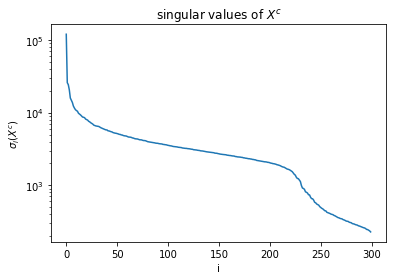

In [7]:
plt.plot(s)
plt.yscale('log')
plt.title(r'singular values of $X^c$')
plt.xlabel('i')
plt.ylabel(r'$\sigma_i(X^c)$')
plt.show()